In [1]:
var LEN_YEARS = 5;
var TOP_N_REPOS = 10;

var openDigger = require('../src/open_digger');
var year = 2023, startMonth = 1, endMonth = 12, startYear = year - LEN_YEARS + 1;
var years = Array.from({ length: LEN_YEARS }, (_, i) => i + startYear); // [2019, 2020, 2021, 2022, 2023]
var baseOptions = {
    startYear, endYear: year,
    startMonth, endMonth,
    groupTimeRange: 'year',
    order: 'DESC'
};

# 以openrank及activity降序对比子领域

In [ ]:
openDigger.index.openrank.getRepoOpenrank({
    ...baseOptions, 
    labelUnion: [':technology/database'], 
    startYear: year, endYear: year, 
    groupBy: 'Tech-1', 
    limit: -1
}).then(data => {
    var data = data.filter(i => i.id.startsWith(':technology/database'));
    data.map(row => {
        var parts = row.name.split(/ - /);
        row.name = parts[parts.length - 1];
        return row;
    });
    console.table(data);
});

Error: connect ECONNREFUSED 47.117.162.161:8123
    at TCPConnectWrap.afterConnect [as oncomplete] (node:net:1161:16)

In [ ]:
var labels = [];
openDigger.index.activity.getRepoActivity({
    ...baseOptions, 
    labelUnion: [':technology/database'], 
    startYear: year, endYear: year, 
    groupBy: 'Tech-1', 
    limit: -1
}).then(data => {
    var data = data.filter(i => i.id.startsWith(':technology/database'));
    data.map(row => {
        var parts = row.name.split(/ - /);
        row.name = parts[parts.length - 1];
        return row;
    });
    labels = data.map((item)=>{ return item.id; });
    console.table(data);
});

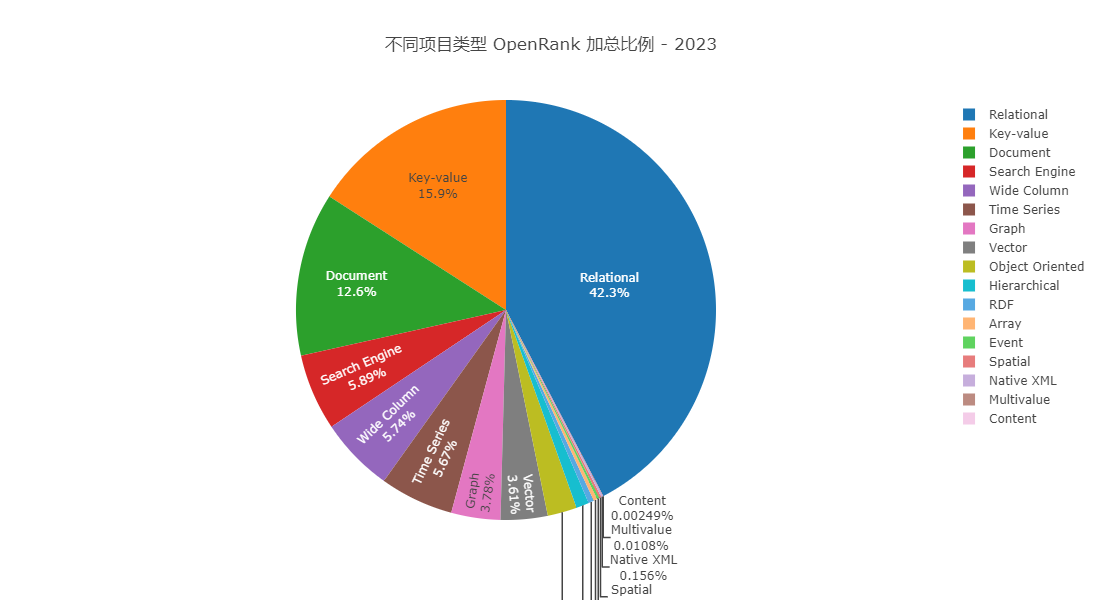

In [379]:
openDigger.index.openrank.getRepoOpenrank({
    labelUnion: [':technology/database'],
    startYear: 2023, endYear: 2023, endMonth: 12,
    groupBy: 'Tech-1',
    groupTimeRange: 'year',
    order: 'DESC',
    limit: -1
}).then(data => {
    var data = data.filter(i => i.id.startsWith(':technology/database'));
    data.map(row => {
        var parts = row.name.split(/ - /);
        row.name = parts[parts.length - 1];
        return row;
    });
    openDigger.render.plotly([
    {labels: data.map(item => item.name), values: data.map(item => item.openrank[0]),type:'pie', name: 'times', textinfo: "label+percent"}], 
    {
        title: '不同项目类型 OpenRank 加总比例 - 2023',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
})

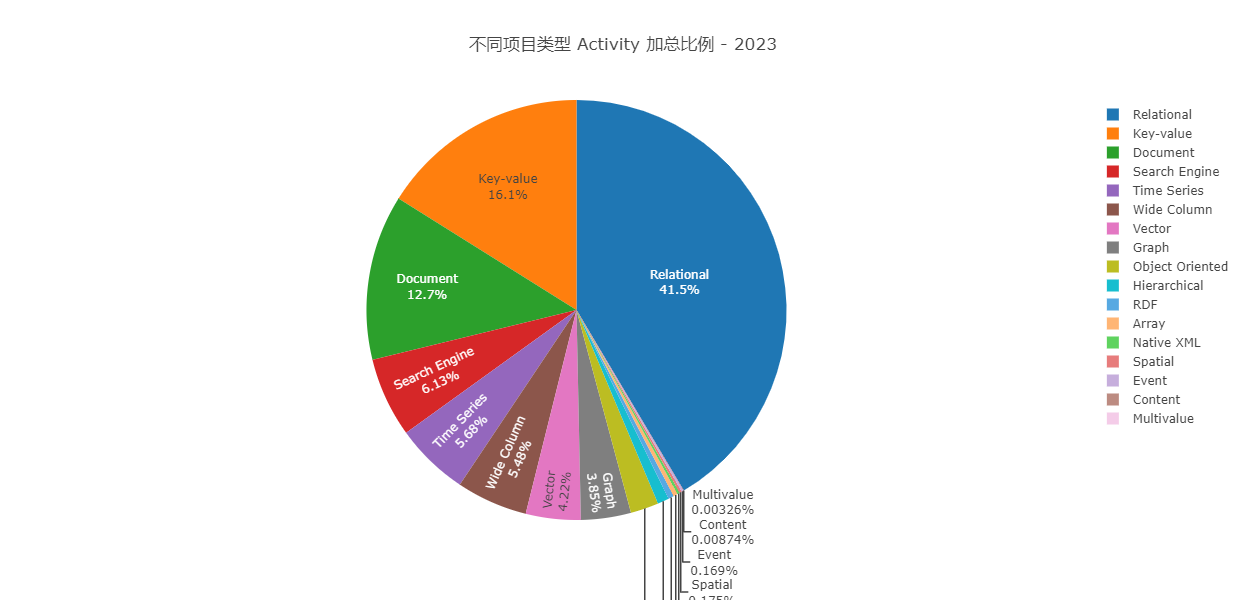

In [380]:
openDigger.index.activity.getRepoActivity({
    labelUnion: [':technology/database'],
    startYear: 2023, endYear: 2023, endMonth: 12,
    groupBy: 'Tech-1',
    groupTimeRange: 'year',
    order: 'DESC',
    limit: -1
}).then(data => {
    var data = data.filter(i => i.id.startsWith(':technology/database'));
    data.map(row => {
        var parts = row.name.split(/ - /);
        row.name = parts[parts.length - 1];
        return row;
    });
    openDigger.render.plotly([
    {labels: data.map(item => item.name), values: data.map(item => item.activity[0]),type:'pie', name: 'times', textinfo: "label+percent"}], 
    {
        title: '不同项目类型 Activity 加总比例 - 2023',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
})

# 开源象限图

OpenRank-CommunityVolume quadrant diagram sampled by Activity

开源象限图共涉及三个度量指标：Activity、Openrank、CommunityVolume。
其中CommunityVolume与open-digger中的Attention指标计算公式相同，即对一定时间内目标项目的star数和fork数的加权求和：`sum(1*star+2*fork)`。

象限图绘制方法：
- 1. 把每个数据库子类按activity选取Top 10的项目；
- 2. 做出 log(openrank)-log(communityvolume) 的 log(x)-log(y) 散点图, log的底数均为2，分别表示空间影响力openrank与时间影响力communityvolume衰减到1所需的半衰次数；
- 3. 以图上所有点的横坐标均值所对应的纵向线作为纵轴，以图上所有点的纵坐标均值所对应的横向线作为横轴划分为四个象限。

三个度量指标：
- OpenRank: see OpenRank in [open-digger](https://github.com/X-lab2017/open-digger?tab=readme-ov-file) and [user_docs](https://open-digger.x-lab.info/docs/user_docs/metrics/openrank/global_openrank)
- Activity: see Activity in [open-digger](https://github.com/X-lab2017/open-digger?tab=readme-ov-file)
- CommunityVolume: `sum(1*star+2*fork)` or see Attention in [open-digger](https://github.com/X-lab2017/open-digger?tab=readme-ov-file)

In [ ]:
console.log(labels);

In [ ]:
var starWeight = 1;
var forkWeight = 2;
var database = 'opensource';
var table = 'events';
var yearConstraint = `toYear(created_at) = '${year}'`
// var yearConstraint = `toYear(created_at) <= ${year}`
// var yearConstraint = `TRUE`

In [ ]:
fetch = require("node-fetch");
var baseUrl = 'https://oss.x-lab.info/open_digger/github/';

function getValue(dict, key, defaultValue) {
    if (key in dict) {
        return dict[key];
    } else {
        return defaultValue;
    }
}

//Makes the request
async function getJSONdata(urls) {
    const data = await urls.map((url) => {
        return fetch(url)
        .then((response) => {
            if (!response.ok) {
                console.log(`fetch ${url} failed!`);
            } else {
                return response.json();
            }
        })
    }
    );
    return await Promise.all(data); 
}

async function getRepoMetricValues(repoNames, year, metricType){
    year = year.toString();
    
    var urls = [];
    for(let i=0; i<repoNames.length; i++) {
        var name = repoNames[i];
        var type = metricType;
        var url = `${baseUrl}${name}/${type}.json`;
        urls.push(url);
    }
    return getJSONdata(urls)
    .then((data) => {
        var result = [];
        for(let i=0; i<repoNames.length; i++) {
            var value;
            var item = data[i];
            if (year in item) {
                value = item[year];
            } else {
                value = 0;
                for (let j=1; j<=12; j++) {
                    var month = j;
                    value += parseFloat(getValue(item, `${year}-${month.toString().padStart(2, '0')}`, 0));
                }
            }
            result.push({
                name: repoNames[i],
                [metricType]: value.toFixed(2)
            })
        }
        return result;
    });
}

In [ ]:
function mergeColObj(data) {
    var dataT = [];
    for(let i=0; i<data.length; i++){
        for (let j=0; j<data[i].length; j++){
            if(dataT.length < j+1){
                dataT.push([]);
            }
            dataT[j].push(data[i][j]);
        }
    }
    var result = [];
    for(let i=0; i<dataT.length; i++){
        if(result.length < i+1){
            result.push({});
        }
        for (let j=0; j<dataT[i].length; j++){
            result[i] = Object.assign(result[i], dataT[i][j]);
        }
    }
    return result;
}

function echartsFormat(data) {
    return data.map(row => {
        return {
            // id: row.id,
            // platform: row.platform,
            name: row.name,
            openrank: row.openrank,
            activity: row.activity,
            communityvolume: row.attention
        };
    });
}

In [ ]:
function getCateFromLabel(label){
    var parts = label.split(/\//);
    return parts[parts.length - 1];
}

In [ ]:
function filterRepoNames(label, limit, year){
    console.log(label);
    if(!limit) {limit = 10;}
    if(!year) {year = 2023;}
    return openDigger.index.activity.getRepoActivity({
        labelUnion: [label],
        startYear: year, endYear: year, startMonth: 1, endMonth: 12,
        groupTimeRange: 'year', limit: limit, order: 'DESC',
    }).then(data => {var repoNames = data.map((item)=>{ return item.name; });
                     console.table(data);
                     return repoNames;
                    });
}

In [ ]:
function getEchartsOption(dataDict) {
    var echartsOption = `
option = {
  title: {
      text: 'DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram',
      subtext: 'Sampled from: DB-Engines 2023 & dbdb.io 2023 & GitHub logs 2023 \\nlogbases = (2, 2)'
  },
  grid: {
      left: '8%',
      right: '8%',
      top: '10%',
      bottom: '3%',
      containLabel: true
  },
  tooltip: {
      trigger: 'axis',
      showDelay : 0,
      axisPointer:{
          show: true,
          type : 'cross',
          lineStyle: {
              type : 'dashed',
              width : 1
          },
      }
  },
  toolbox: {
    show: false,
    feature: {
        dataZoom: {},
        brush: {
            type: ['rect', 'polygon', 'clear']
        }
    }
  },
  legend: {
      bottom: "0%",
      left: "center"
  },
  xAxis: [
      {
        type : 'value',
        logBase: 2,
        scale: true,
        interval: 1,
        axisLabel : {
            formatter: '{value}'
        },
        splitLine: {
            show: false
        }
      }
  ],
  yAxis: [
      {
        type : 'value',
        logBase: 2,
        scale: true,
        interval: 1,
        axisLabel : {
            formatter: '{value}'
        },
        splitLine: {
            show: false
        }
      }
  ],
  series: [],
};

var dataDict = ${JSON.stringify(dataDict)};

// subCategory filter
var subCateIndex = 0;
var dataKeys = Object.keys(dataDict);
// dataDict = {[dataKeys[subCateIndex]]: dataDict[dataKeys[subCateIndex]]};

// log-log
function loglog(data) {return data.map(function (item) {
    return {
        name: item.name,
        openrank: Math.log(item.openrank), 
        communityvolume: Math.log(item.communityvolume)
      }
    });
}

// formatter
function format(data) {return data.map(function (item) {
      return {
        value: [item.openrank, item.communityvolume], 
        label: {
          formatter: item.name,
          textStyle: {fontSize: 10}
        },
      }
    });
}

var length = Object.keys(dataDict).length;
for (let i = 0; i < length; i++) {
  var key = Object.keys(dataDict)[i];
  var value = dataDict[key];
  data = loglog(value);
  data = format(data);
  if (option.series[i] === undefined) {
    option.series[i] = {};
  }
  option.series[i] = Object.assign(option.series[i], {
      type:'scatter',
      symbolSize: 30,
      label: {
        show: true,
        position: 'top'
      }
    });
  option.series[i].name = key;
  option.series[i].data = data;
}
option.legend.data = Object.keys(dataDict);

// limit
function getMinMax(arr, idx) {
    return {
      min: Math.min.apply(null, arr.map(function (e) {
        return e.value[idx]
      })),
      max: Math.max.apply(null, arr.map(function (e) {
        return e.value[idx]
      }))
    }
  }
var allX = [];
var allY = [];
for (let i = 0; i < length; i++) {
  data = option.series[i].data;
  allX = allX.concat(data.map(function (e) {
        return e.value[0];
      }))
  allY = allY.concat(data.map(function (e) {
        return e.value[1];
      }));
}
var minX = Math.min(...allX);
var maxX = Math.max(...allX);
var minY = Math.min(...allY);
var maxY = Math.max(...allY);
option.xAxis[0].min = Math.floor(minX) - 1;
option.xAxis[0].max = Math.ceil(maxX) + 1;
option.yAxis[0].min = Math.floor(minY) - 1;
option.yAxis[0].max = Math.ceil(maxY) + 1;

// axis
var arr = [allX, allY]
var transposedArr = arr[0].map((_, colIndex) => {
    return arr.map(row => row[colIndex]);
});
function calculateAverage(arr) {
  if (arr.length === 0) {
    return 0;
  }

  let sum = 0;
  for (let i = 0; i < arr.length; i++) {
    sum += arr[i];
  }

  return sum / arr.length;
}
option.series.push({
  type:'scatter',
  markLine : {
    lineStyle: {
      symbol:['circle', 'arrow'],
      normal: {
          color: 'white',
          type: 'solid'
      }
    },
    label:{
          show: true,
          position: "end", //将警示值放在哪个位置，start middle end 开头 中间 结尾
      },
    data: [
        {xAxis: calculateAverage(allX), label:{formatter: 'CommunityVolume'}},
        {yAxis: calculateAverage(allY), label:{formatter: 'OpenRank'}}
    ]
  },
})
    `
    return echartsOption;
}

## 1. 以活跃度降序采样开源数据库领域Top 100项目绘制象限图

In [61]:
// global top-100 activity repos
var repoNames = [];
var label = ':technology/database';
filterRepoNames(label, limit=100).then((sampleRepoNames) => {repoNames = sampleRepoNames});

:technology/database
┌─────────┬─────────────┬──────────┬─────────────────────────────────────┬──────────────┬──────────────┬───────────────┬─────────────┬─────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │                name                 │   activity   │ participants │ issue_comment │ open_issue  │  open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼─────────────────────────────────────┼──────────────┼──────────────┼───────────────┼─────────────┼─────────────┼────────────────┼─────────────┼───────────┤
│    0    │ '60246359'  │ 'GitHub' │       'ClickHouse/ClickHouse'       │ [ 12418.45 ] │  [ '4439' ]  │  [ '27230' ]  │ [ '3750' ]  │ [ '8314' ]  │  [ '11573' ]   │ [ '7361' ]  │ undefined │
│    1    │ '99919302'  │ 'GitHub' │           'apache/doris'            │ [ 12244.03 ] │  [ '2750' ]  │  [ '82001' ]  │ [ '1475' ]  │ [ '10836' ] │  [ '15234' ]   │ [ '9065' ]  │ undefined │
│    2    │ '402945

In [64]:
// 分别调用API提高fetch成功率
var dataOpenRank = [];
getRepoMetricValues(repoNames, 2023, 'openrank').then((data) => {dataOpenRank = data;});

In [66]:
var dataActivity = [];
getRepoMetricValues(repoNames, 2023, 'activity').then((data) => {dataActivity = data;});

In [67]:
var dataAttention = [];
getRepoMetricValues(repoNames, 2023, 'attention').then((data) => {dataAttention = data;});

In [77]:
var dataDict = {};
var dataFormated = mergeColObj([dataOpenRank, dataActivity, dataAttention]);
dataDict[getCateFromLabel(label)] = echartsFormat(dataFormated);
console.log(dataDict);

{
  database: [
    {
      name: 'ClickHouse/ClickHouse',
      openrank: '4916.87',
      activity: '12418.45',
      communityvolume: '8212.00'
    },
    {
      name: 'apache/doris',
      openrank: '4262.44',
      activity: '12244.03',
      communityvolume: '6002.00'
    },
    {
      name: 'StarRocks/starrocks',
      openrank: '3167.61',
      activity: '10471.99',
      communityvolume: '4674.00'
    },
    {
      name: 'cockroachdb/cockroach',
      openrank: '3425.38',
      activity: '10065.19',
      communityvolume: '3099.00'
    },
    {
      name: 'elastic/elasticsearch',
      openrank: '3706.38',
      activity: '9895.12',
      communityvolume: '8330.00'
    },
    {
      name: 'pingcap/tidb',
      openrank: '2186.94',
      activity: '8008.00',
      communityvolume: '3711.00'
    },
    {
      name: 'apache/spark',
      openrank: '2625.92',
      activity: '6565.93',
      communityvolume: '6529.00'
    },
    {
      name: 'milvus-io/milvus',
      openra

In [89]:
echartsOption = getEchartsOption(dataDict);
console.log(echartsOption);


option = {
  title: {
      text: 'DBMS OSS OpenRank-CommunityVolume log-log quadrant diagram',
      subtext: 'Sampled from: DB-Engines 2023 & dbdb.io 2023 & GitHub logs 2023 \nlogbases = (2, 2)'
  },
  grid: {
      left: '8%',
      right: '8%',
      top: '10%',
      bottom: '3%',
      containLabel: true
  },
  tooltip: {
      trigger: 'axis',
      showDelay : 0,
      axisPointer:{
          show: true,
          type : 'cross',
          lineStyle: {
              type : 'dashed',
              width : 1
          },
      }
  },
  toolbox: {
    show: false,
    feature: {
        dataZoom: {},
        brush: {
            type: ['rect', 'polygon', 'clear']
        }
    }
  },
  legend: {
      bottom: "0%",
      left: "center"
  },
  xAxis: [
      {
        type : 'value',
        logBase: 2,
        scale: true,
        interval: 1,
        axisLabel : {
            formatter: '{value}'
        },
        splitLine: {
            show: false
        }
      }
  ],
  yA

## 2. 以活跃度降序分层采样开源数据库领域各子领域Top 10项目绘制象限图

数据库领域子类标签共计18个，选取2023年活跃度占比超过1%的前9个类别统计分析，绘制开源象限图如下：

In [ ]:
function fectchMetricValues(repoNames, year){  // 查询项目较少时可以合并在一起处理
    return Promise.all(
        [getRepoMetricValues(repoNames, year, 'openrank'),
         getRepoMetricValues(repoNames, year, 'activity'),
         getRepoMetricValues(repoNames, year, 'attention'),
        ]
    ).then((data) => {
        var data = mergeColObj(data);
        return echartsFormat(data);
    })
}

In [91]:
var dataDict = {};

In [92]:
var label = labels[0];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/relational
┌─────────┬─────────────┬──────────┬─────────────────────────────┬──────────────┬──────────────┬───────────────┬─────────────┬─────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │            name             │   activity   │ participants │ issue_comment │ open_issue  │  open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼─────────────────────────────┼──────────────┼──────────────┼───────────────┼─────────────┼─────────────┼────────────────┼─────────────┼───────────┤
│    0    │ '60246359'  │ 'GitHub' │   'ClickHouse/ClickHouse'   │ [ 12418.45 ] │  [ '4439' ]  │  [ '27230' ]  │ [ '3750' ]  │ [ '8314' ]  │  [ '11573' ]   │ [ '7361' ]  │ undefined │
│    1    │ '99919302'  │ 'GitHub' │       'apache/doris'        │ [ 12244.03 ] │  [ '2750' ]  │  [ '82001' ]  │ [ '1475' ]  │ [ '10836' ] │  [ '15234' ]   │ [ '9065' ]  │ undefined │
│    2    │ '402945349' │ 'GitHub' │    'StarRoc

In [93]:
var label = labels[1];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/key_value
┌─────────┬─────────────┬──────────┬─────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │          name           │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼─────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │ '41986369'  │ 'GitHub' │     'pingcap/tidb'      │  [ 8008 ]   │  [ '1731' ]  │ [ '111077' ]  │ [ '3083' ] │ [ '5875' ] │   [ '9205' ]   │ [ '4378' ]  │ undefined │
│    1    │ '28449431'  │ 'GitHub' │   'scylladb/scylladb'   │ [ 4408.83 ] │  [ '1016' ]  │  [ '29213' ]  │ [ '1635' ] │ [ '2093' ] │  [ '10916' ]   │  [ '698' ]  │ undefined │
│    2    │  '5349565'  │ 'GitHub' │    'prestodb/presto'    │ [ 3979.31 ] │  [ '130

In [363]:
var label = labels[2];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/document
┌─────────┬─────────────┬──────────┬─────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │          name           │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼─────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │  '507775'   │ 'GitHub' │ 'elastic/elasticsearch' │ [ 9895.12 ] │  [ '2802' ]  │  [ '27648' ]  │ [ '2317' ] │ [ '7582' ] │  [ '17670' ]   │ [ '6778' ]  │ undefined │
│    1    │  '5349565'  │ 'GitHub' │    'prestodb/presto'    │ [ 3979.31 ] │  [ '1303' ]  │  [ '5566' ]   │ [ '755' ]  │ [ '1784' ] │   [ '6490' ]   │ [ '1223' ]  │ undefined │
│    2    │ '60377070'  │ 'GitHub' │  'vespa-engine/vespa'   │ [ 2582.42 ] │  [ '460'

In [364]:
var label = labels[3];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/search_engine
┌─────────┬─────────────┬──────────┬─────────────────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │                name                 │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼─────────────────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │  '507775'   │ 'GitHub' │       'elastic/elasticsearch'       │ [ 9895.12 ] │  [ '2802' ]  │  [ '27648' ]  │ [ '2317' ] │ [ '7582' ] │  [ '17670' ]   │ [ '6778' ]  │ undefined │
│    1    │ '334274271' │ 'GitHub' │   'opensearch-project/OpenSearch'   │ [ 6369.8 ]  │  [ '1869' ]  │  [ '34800' ]  │ [ '2215' ] │ [ '3245' ] │  [ '12488' ]   │ [ '2780' ]  │ undefined │
│    2    │ '6037707

In [ ]:
var label = labels[4];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/time_series


Error: connect ECONNREFUSED 47.117.162.161:8123
    at TCPConnectWrap.afterConnect [as oncomplete] (node:net:1161:16)

In [366]:
var label = labels[5];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/wide_column
┌─────────┬─────────────┬──────────┬───────────────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │               name                │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼───────────────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │ '28449431'  │ 'GitHub' │        'scylladb/scylladb'        │ [ 4408.83 ] │  [ '1016' ]  │  [ '29213' ]  │ [ '1635' ] │ [ '2093' ] │  [ '10916' ]   │  [ '698' ]  │ undefined │
│    1    │  '5349565'  │ 'GitHub' │         'prestodb/presto'         │ [ 3979.31 ] │  [ '1303' ]  │  [ '5566' ]   │ [ '755' ]  │ [ '1784' ] │   [ '6490' ]   │ [ '1223' ]  │ undefined │
│    2    │  '6358188'  │ 'GitHu

In [367]:
var label = labels[6];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/vector
┌─────────┬─────────────┬──────────┬─────────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │            name             │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼─────────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │ '208728772' │ 'GitHub' │     'milvus-io/milvus'      │ [ 6488.35 ] │  [ '1710' ]  │  [ '49140' ]  │ [ '2717' ] │ [ '4191' ] │   [ '2280' ]   │ [ '3444' ]  │ undefined │
│    1    │ '546206616' │ 'GitHub' │    'chroma-core/chroma'     │ [ 2216.31 ] │  [ '1216' ]  │  [ '4387' ]   │ [ '690' ]  │ [ '641' ]  │   [ '1562' ]   │  [ '454' ]  │ undefined │
│    2    │ '55072677'  │ 'GitHub' │     'weaviate/weaviate'     │ 

In [368]:
var label = labels[7];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/graph
┌─────────┬─────────────┬──────────┬──────────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │             name             │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼──────────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │  '2649214'  │ 'GitHub' │     'arangodb/arangodb'      │ [ 2096.47 ] │  [ '546' ]   │  [ '1344' ]   │ [ '158' ]  │ [ '2013' ] │   [ '4176' ]   │ [ '1881' ]  │ undefined │
│    1    │ '436658287' │ 'GitHub' │    'surrealdb/surrealdb'     │ [ 1885.04 ] │  [ '910' ]   │  [ '2324' ]   │ [ '687' ]  │ [ '648' ]  │   [ '1096' ]   │  [ '543' ]  │ undefined │
│    2    │ '276293034' │ 'GitHub' │         'apache/age'      

In [369]:
var label = labels[8];
filterRepoNames(label).then((sampleRepoNames) => {
    fectchMetricValues(sampleRepoNames, year).then((data) => {dataDict[getCateFromLabel(label)] = data;});
});

:technology/database/object_oriented
┌─────────┬─────────────┬──────────┬──────────────────────────────┬─────────────┬──────────────┬───────────────┬────────────┬────────────┬────────────────┬─────────────┬───────────┐
│ (index) │     id      │ platform │             name             │  activity   │ participants │ issue_comment │ open_issue │ open_pull  │ review_comment │ merged_pull │  details  │
├─────────┼─────────────┼──────────┼──────────────────────────────┼─────────────┼──────────────┼───────────────┼────────────┼────────────┼────────────────┼─────────────┼───────────┤
│    0    │ '351806852' │ 'GitHub' │     'neondatabase/neon'      │ [ 2428.2 ]  │  [ '502' ]   │  [ '5860' ]   │ [ '671' ]  │ [ '1900' ] │   [ '7986' ]   │ [ '1472' ]  │ undefined │
│    1    │ '95817032'  │ 'GitHub' │       'edgedb/edgedb'        │ [ 1473.58 ] │  [ '494' ]   │  [ '1574' ]   │ [ '589' ]  │ [ '984' ]  │   [ '1435' ]   │  [ '881' ]  │ undefined │
│    2    │  '1917262'  │ 'GitHub' │      'realm/real

In [94]:
console.log(dataDict);

{
  relational: [
    {
      name: 'ClickHouse/ClickHouse',
      openrank: '4916.87',
      activity: '12418.45',
      communityvolume: '8212.00'
    },
    {
      name: 'apache/doris',
      openrank: '4262.44',
      activity: '12244.03',
      communityvolume: '6002.00'
    },
    {
      name: 'StarRocks/starrocks',
      openrank: '3167.61',
      activity: '10471.99',
      communityvolume: '4674.00'
    },
    {
      name: 'cockroachdb/cockroach',
      openrank: '3425.38',
      activity: '10065.19',
      communityvolume: '3099.00'
    },
    {
      name: 'pingcap/tidb',
      openrank: '2186.94',
      activity: '8008.00',
      communityvolume: '3711.00'
    },
    {
      name: 'apache/spark',
      openrank: '2625.92',
      activity: '6565.93',
      communityvolume: '6529.00'
    },
    {
      name: 'trinodb/trino',
      openrank: '2684.58',
      activity: '6271.21',
      communityvolume: '3364.00'
    },
    {
      name: 'facebookincubator/velox',
      openr

In [ ]:
echartsOption = getEchartsOption(dataDict);
console.log(echartsOption);

---

In [9]:
// subCategory filter 降序查看子类情况
var subCateIndex = 0;
var dataKeys = Object.keys(dataDict);
var subDataDict = {[dataKeys[subCateIndex]]: dataDict[dataKeys[subCateIndex]]};
function desc(dataDict, key){
    return dataDict.sort(function (a, b) {
        return b[key]  - a[key] ; // 返回负值表示交换位置
    });
}
console.table(desc(subDataDict[dataKeys[subCateIndex]], 'communityvolume'));

┌─────────┬─────────────────────────────┬───────────┬────────────┬─────────────────┐
│ (index) │            name             │ openrank  │  activity  │ communityvolume │
├─────────┼─────────────────────────────┼───────────┼────────────┼─────────────────┤
│    0    │   'ClickHouse/ClickHouse'   │ '4916.87' │ '12418.45' │    '8212.00'    │
│    1    │       'apache/spark'        │ '2625.92' │ '6565.93'  │    '6529.00'    │
│    2    │       'apache/doris'        │ '4262.44' │ '12244.03' │    '6002.00'    │
│    3    │       'apache/flink'        │ '1787.59' │ '4397.27'  │    '5123.00'    │
│    4    │    'StarRocks/starrocks'    │ '3167.61' │ '10471.99' │    '4674.00'    │
│    5    │       'pingcap/tidb'        │ '2186.94' │ '8008.00'  │    '3711.00'    │
│    6    │       'trinodb/trino'       │ '2684.58' │ '6271.21'  │    '3364.00'    │
│    7    │   'cockroachdb/cockroach'   │ '3425.38' │ '10065.19' │    '3099.00'    │
│    8    │ 'risingwavelabs/risingwave' │ '1524.08' │ '4607.42'  

In [374]:
// repo_communityvolume 备用查询语句
var repoNamesStr = repoNames.join('\', \'');
openDigger.driver.clickhouse.query(`
SELECT event_list.repo_id AS repo_id,event_list.repo_name as repo_name, round(sum(event_list.score),2) AS repo_communityvolume 
FROM
(SELECT
wc.repo_id AS repo_id, wc.repo_name as repo_name, ${starWeight}*wc.count+${forkWeight}*fc.count AS score
FROM
(SELECT repo_id, repo_name, COUNT(*) count FROM ${database}.${table} WHERE type='WatchEvent' AND repo_name in ('${repoNamesStr}') AND ${yearConstraint} AND platform='GitHub' GROUP BY repo_id,repo_name) AS wc
LEFT JOIN
(SELECT repo_id, repo_name, COUNT(*) count FROM ${database}.${table} WHERE type='ForkEvent' AND repo_name in ('${repoNamesStr}') AND ${yearConstraint} AND platform='GitHub' GROUP BY repo_id,repo_name) AS fc
ON wc.repo_id=fc.repo_id) AS event_list
GROUP BY repo_id, repo_name
ORDER BY repo_communityvolume
`, { format: 'JSONEachRow' }).then(data => {
    console.table(data);
});

┌─────────┬─────────────┬─────────────────────────────────────┬──────────────────────┐
│ (index) │   repo_id   │              repo_name              │ repo_communityvolume │
├─────────┼─────────────┼─────────────────────────────────────┼──────────────────────┤
│    0    │ '75425073'  │            'pubkey/rxdb'            │        '2111'        │
│    1    │ '20089857'  │           'apache/hbase'            │        '814'         │
│    2    │ '19961085'  │           'apache/pinot'            │        '1040'        │
│    3    │  '6650539'  │            'neo4j/neo4j'            │        '1761'        │
│    4    │ '510607652' │       'pocketbase/pocketbase'       │       '11081'        │
│    5    │ '341631350' │           'apache/lucene'           │        '1312'        │
│    6    │ '564689243' │        'man-group/ArcticDB'         │        '912'         │
│    7    │ '166515022' │           'trinodb/trino'           │        '3364'        │
│    8    │ '302827809' │       'datafusela

In [207]:
// scatter-pie diagram 备用样式

var data = [
  { Product: 'Cake', Sales: 123, Price: 1, Year: 2011 },
  { Product: 'Dumpling', Sales: 341, Price: 2, Year: 2011 },
  { Product: 'Cake', Sales: 143, Price: 3, Year: 2012 },
  { Product: 'Dumpling', Sales: 241, Price: 4, Year: 2012 }
];

var xmin = 0;
var xmax = 600;
var ymin = 0;
var ymax = 12;

// define your x y and radius
var getXFromRow = (row) => {return getWeightedSumFromRow(row, weightDict={Sales:1})};
var getYFromRow = (row) => {return getWeightedSumFromRow(row, weightDict={Price:1})};
var getRadiusFromRow = (row) => {return Math.log(row['Sales']*row['Price']) * 2;};

options = `
// scatter-pie https://echarts.apache.org/examples/zh/editor.html?c=scatter-simple
var data = ${JSON.stringify(data)};

var xmin = ${xmin};
var xmax = ${xmax};
var ymin = ${ymin};
var ymax = ${ymax};

// define your x y and radius
var getXFromRow = ${getXFromRow};
var getYFromRow = ${getYFromRow};
var getRadiusFromRow = ${getRadiusFromRow};

function getColValSet(data, dimension) {
  var arr = data.map((row) => {
      return row[dimension];
  });
  var uniqueArr = [];
  for (let i=0; i < arr.length; i++) {
    if (uniqueArr.indexOf(arr[i]) === -1) {
      uniqueArr.push(arr[i]);
    }
  }
  return uniqueArr;
}

function getTransforms(data, dimension) {
  var uniqueArr = getColValSet(data, dimension);
  return uniqueArr.map((uniqueGroupKey) => {
    return {
      transform: {
        type: 'filter',
        config: { dimension: dimension, value: uniqueGroupKey }
      }
    }
  })
}

function getAccumulations (transforms, data, getWeightFromRow) {
    transformConfigs = transforms.map((row) => {
        return {[row.transform.config.dimension]: row.transform.config.value};
    });
    var result = [];
    for(let i=0; i<transformConfigs.length; i++) {
        var accumulation = 0;
        var tempConfig = transformConfigs[i];
        var tempConfigKey = Object.keys(tempConfig)[0];
        var tempConfigValue = Object.values(tempConfig)[0];
        for(let j=0; j<data.length; j++) {
            var currData = data[j];
            var tempWeight = 0;
            if(currData[tempConfigKey] === tempConfigValue) {
                tempWeight = getWeightFromRow(currData);
            }
            accumulation += tempWeight;
        }
        result.push(accumulation);
    }
  return result;
}


function getSeries(transforms, data) {
  var radius = getAccumulations(transforms, data, getRadiusFromRow);
  return radius.map((r, index) => {
    return {
      type: 'pie',
      radius: r,
      label: {show: false},
      datasetIndex: index + 1
    }
  })
}

function offsetCenter(arr) {
  magicNum = {
    xscope: 772,
    yscope: 620,
    xOriginOffset: 97,
    yOriginOffset: 680,
  };
  var xscale = magicNum.xscope/(xmax-xmin);
  var yscale = magicNum.yscope/(ymax-ymin);
  relpoint = [magicNum.xOriginOffset-xmin*xscale, magicNum.yOriginOffset+ymin*yscale];
  return [relpoint[0] + arr[0]*xscale, relpoint[1] - arr[1]*yscale]
}

function getWeightedSumFromRow(row, weightDict) {
    var weightKeys = Object.keys(weightDict);
    var tempWeight = 0;
    for(let k=0; k<weightKeys.length; k++) {
        var tempWeightKey = weightKeys[k];
        tempWeight += row[tempWeightKey]*weightDict[tempWeightKey];
    }
    return tempWeight;
}

function getXY(transforms, data) {
  var X = getAccumulations(transforms, data, getXFromRow);
  var Y = getAccumulations(transforms, data, getYFromRow);
  var result = [];
  for(let i=0; i<X.length; i++) {
    tempCoordinate = {
      x: X[i],
      y: Y[i]
    };
    result.push(tempCoordinate);
  }
  return result;
}

function getMediaSeries(transforms, data){
  var xyDicts = Object.values(getXY(transforms, data));
  var xy = [];
  for (let i = 0; i < xyDicts.length; i++) {
      var rowData = Object.values(xyDicts[i]);
      xy.push(rowData);
  }
  var centerConfigs = xy.map((coordinate) => {
    return {center: offsetCenter(coordinate)}
  })
  var refScatters = [{
          type: 'scatter',
          data: xy,
          symbolSize: 5  //the marker size of reference points
        }];
  return centerConfigs.concat(refScatters);
}

var transforms = getTransforms(data, 'Year');
var sourceDataOption = [{
    source: data,
  }]
var dataset = sourceDataOption.concat(transforms);
var series = getSeries(transforms, data);
var legendData = getColValSet(data, 'Product');
var mediaSeries = getMediaSeries(transforms, data);
option = {
  dataset: dataset,
  series: series,
  // Optional. Only for responsive layout:
  media: [
    {
      query: { minAspectRatio: 1 },

      option: {
        tooltip: {},
        legend: {
          data: legendData,
          bottom: 10
        },
        xAxis: {
          min: xmin,
          max: xmax
        },
        yAxis: {
          min: ymin,
          max: ymax
        },
        series: mediaSeries,
      }
    },
  ]
};

`

console.log(options);


// scatter-pie https://echarts.apache.org/examples/zh/editor.html?c=scatter-simple
var data = [{"Product":"Cake","Sales":123,"Price":1,"Year":2011},{"Product":"Dumpling","Sales":341,"Price":2,"Year":2011},{"Product":"Cake","Sales":143,"Price":3,"Year":2012},{"Product":"Dumpling","Sales":241,"Price":4,"Year":2012}];

var xmin = 0;
var xmax = 600;
var ymin = 0;
var ymax = 12;

// define your x y and radius
var getXFromRow = (row) => {return getWeightedSumFromRow(row, weightDict={Sales:1})};
var getYFromRow = (row) => {return getWeightedSumFromRow(row, weightDict={Price:1})};
var getRadiusFromRow = (row) => {return Math.log(row['Sales']*row['Price']) * 2;};

function getColValSet(data, dimension) {
  var arr = data.map((row) => {
      return row[dimension];
  });
  var uniqueArr = [];
  for (let i=0; i < arr.length; i++) {
    if (uniqueArr.indexOf(arr[i]) === -1) {
      uniqueArr.push(arr[i]);
    }
  }
  return uniqueArr;
}

function getTransforms(data, dimension) {
  var uniqueArr =